In [1]:
%cd ../../
%ls

c:\ai\workspace\PhD\cir3_anonym\cirrr
 Volume in drive C is OS
 Volume Serial Number is BE2B-F904

 Directory of c:\ai\workspace\PhD\cir3_anonym\cirrr

17/06/2024  12:20    <DIR>          .
16/06/2024  02:48    <DIR>          ..
16/06/2024  14:51                80 .env
16/06/2024  16:52             3,372 .gitignore
16/06/2024  14:46    <DIR>          aimw
16/06/2024  05:09    <DIR>          conf
16/06/2024  17:16             1,434 docker-compose.yml
16/06/2024  17:38    <DIR>          inference-engines
16/06/2024  17:12    <DIR>          proxy
17/06/2024  17:24    <DIR>          quick-run
16/06/2024  15:55    <DIR>          re
17/06/2024  17:25             2,003 README.md
               4 File(s)          6,889 bytes
               8 Dir(s)  337,386,766,336 bytes free


In [2]:
from aimw.app.core.log_config import LoggingSettings, setup_app_logging
from loguru import logger
from datetime import datetime

# setup logging as early as possible
setup_app_logging(config=LoggingSettings())
current_datetime = datetime.now()
formatted_string = current_datetime.strftime('%Y%m%d-%H%M%S')
logger.info(formatted_string)

2024-06-17 17:32:56.287 | INFO     | __main__:<module>:9 - 20240617-173256


### Setup Env Vars

In [3]:
import os

from aimw.app.core.ai_config import get_ai_settings

if get_ai_settings().langchain_api_key and len(get_ai_settings().langchain_api_key) > 30:
    os.environ["LANGCHAIN_API_KEY"] = get_ai_settings().langchain_api_key
    os.environ["LANGCHAIN_PROJECT"] = "CIR3_" + formatted_string
    os.environ["LANGCHAIN_TRACING_V2"] = "true"
    logger.info("Continue using LangChain Tracing ...")

os.environ["GROQ_API_KEY"] = get_ai_settings().groq_api_key
os.environ["LANGCHAIN_TRACING_V2"] = "false"


2024-06-17 17:32:56.328 | INFO     | __main__:<module>:9 - Continue using LangChain Tracing ...


In [4]:
from aimw.app.services.factory.model_factory_service import Factory
from aimw.app.schemas.enum.ai_enums import Role
from aimw.app.resources.icl_templates import icl_cir3_templates
from aimw.app.exceptions.exceptions import ValueTypeException
from aimw.app.schemas.models.decentralized_agents_group import Writers
from aimw.app.services.factory import runnable_system


In [5]:
document = """Non-qualified tax deferred annuities accumulate tax deferred and upon distributions are taxed as ordinary income at the effective tax bracket rate of the annuity policy owner. Basis is distributed tax free . Qualified annuity distributions are taxed as ordinary income at the effective tax bracket rate of the annuity policy owner . There is no basis.
"""

### Classifier Agent

In [6]:
classifier_response = runnable_system.runnable_cir3.classifier_runnable.invoke(
    {"M": 3, "document": document}
)
logger.info(classifier_response)

2024-06-17 17:33:00.334 | INFO     | __main__:<module>:4 - {'subtopics': ['finance', 'annuity', 'tax']}


### Moderator Agent

In [7]:
moderator_response = runnable_system.runnable_cir3.moderator_runnable.invoke(
    {
        "M": 3,
        "N": 5,
        "document": document,
        "subtopics": classifier_response,
        "moderator_examplar": icl_cir3_templates.moderator_examplar,
    }
)
logger.info(f"type(moderator_response): {type(moderator_response)}")
logger.info(moderator_response)

2024-06-17 17:33:01.962 | INFO     | __main__:<module>:10 - type(moderator_response): <class 'list'>
2024-06-17 17:33:01.963 | INFO     | __main__:<module>:11 - [{'writer_id': 1, 'perspective': 'tax', 'task': "Generate 5 question-answer pairs that are directly grounded in the document's content from the perspective of a tax expert.", 'instructions': ['1. Assign perspective to the writer i based on the subtopic i.', '2. Analyze the document in-depth from your assigned perspective.', "3. Generate up to 5 question-answer pairs that are directly grounded in the document's content.", "4. Reflect on your question-answer pairs with respect to the input document. If you agree that no refinements are needed, return 'agreement' as writer_status, otherwise return 'continue', and output your feedback as 'writer_feedback'.", "5. Format your output as JSON with the following keys: 'question_answer_list', 'writer_feedback', 'writer_status', and 'perspective'."]}, {'writer_id': 2, 'perspective': 'fina

### Writers 

#### Create the group

In [8]:
runnable_system.runnable_cir3.setup_writers_group(moderator_response)
runnable_system.runnable_cir3.writers.describe()

2024-06-17 17:33:02.698 | DEBUG    | aimw.app.schemas.models.decentralized_agents_group:__init__:45 - Concatenating moderator's instructions ...
2024-06-17 17:33:02.698 | DEBUG    | aimw.app.schemas.models.decentralized_agents_group:__init__:50 - modertaor instructions 0: Task: Generate 5 question-answer pairs that are directly grounded in the document's content from the perspective of a tax expert..
Instructions: 1. Assign perspective to the writer i based on the subtopic i. 2. Analyze the document in-depth from your assigned perspective. 3. Generate up to 5 question-answer pairs that are directly grounded in the document's content. 4. Reflect on your question-answer pairs with respect to the input document. If you agree that no refinements are needed, return 'agreement' as writer_status, otherwise return 'continue', and output your feedback as 'writer_feedback'. 5. Format your output as JSON with the following keys: 'question_answer_list', 'writer_feedback', 'writer_status', and 'per

#### Initial Pass

In [9]:
inner_transactive_memory = [] # Init only once per document
outer_transactive_memory = [] # Init only once per document

In [10]:
inner_iter_response = []  # Init at every inner iteration
trans_mem_qas_inner_iter = []  # Init at every inner iteration
trans_mem_feed_inner_iter = []  # Init at every inner iteration
trans_mem_status_inner_iter = []  # Init at every inner iteration

for i, runnable in enumerate(
    runnable_system.runnable_cir3.writers.writers_qadraft_runnables
):
    individual_writer_response = runnable.invoke(
        {
            "document": document,
            "moderator_prompt": runnable_system.runnable_cir3.writers.moderator_instructions[
                i
            ],
        }
    )
    inner_iter_response.append(individual_writer_response)
    trans_mem_qas_inner_iter.append(individual_writer_response["question_answer_list"])
    trans_mem_feed_inner_iter.append(individual_writer_response["writer_feedback"])
    trans_mem_status_inner_iter.append(individual_writer_response["writer_status"])

inner_transactive_memory.append((trans_mem_qas_inner_iter, trans_mem_feed_inner_iter))


logger.info(f"Inner_transactive_memory: {inner_transactive_memory}")
logger.info(f"QAs from last inner iteration: {inner_transactive_memory[-1][0]}")
logger.info(f"Feedback from last inner Iteration {inner_transactive_memory[-1][1]}")
logger.info(f"Status from last inner Iteration {trans_mem_status_inner_iter}")

2024-06-17 17:33:06.435 | INFO     | __main__:<module>:25 - Inner_transactive_memory: [([[{'question': 'What happens to the tax-deferred accumulation of a non-qualified tax-deferred annuity?', 'answer': 'The accumulation is taxed as ordinary income at the effective tax bracket rate of the annuity policy owner.'}, {'question': 'What is the tax treatment of qualified annuity distributions?', 'answer': 'Qualified annuity distributions are taxed as ordinary income at the effective tax bracket rate of the annuity policy owner.'}, {'question': 'What is the tax treatment of non-qualified annuity distributions?', 'answer': 'Non-qualified annuity distributions are taxed as ordinary income at the effective tax bracket rate of the annuity policy owner.'}, {'question': 'Is the basis of a non-qualified annuity distributed tax-free?', 'answer': 'Yes, the basis of a non-qualified annuity is distributed tax-free.'}, {'question': 'Is there a basis for qualified annuity distributions?', 'answer': 'No, t

In [11]:
inner_transactive_memory

[([[{'question': 'What happens to the tax-deferred accumulation of a non-qualified tax-deferred annuity?',
     'answer': 'The accumulation is taxed as ordinary income at the effective tax bracket rate of the annuity policy owner.'},
    {'question': 'What is the tax treatment of qualified annuity distributions?',
     'answer': 'Qualified annuity distributions are taxed as ordinary income at the effective tax bracket rate of the annuity policy owner.'},
    {'question': 'What is the tax treatment of non-qualified annuity distributions?',
     'answer': 'Non-qualified annuity distributions are taxed as ordinary income at the effective tax bracket rate of the annuity policy owner.'},
    {'question': 'Is the basis of a non-qualified annuity distributed tax-free?',
     'answer': 'Yes, the basis of a non-qualified annuity is distributed tax-free.'},
    {'question': 'Is there a basis for qualified annuity distributions?',
     'answer': 'No, there is no basis for qualified annuity distri

#### Inner-refinement cycle - Transactive

In [12]:
runnable_system.runnable_cir3.writers.writers_inner_refine_runnables[0]

PromptTemplate(input_variables=['curmudgeon_feedback', 'document', 'old_question_answer_list', 'old_writer_feedback', 'perspective'], template="<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n    You are an expert writer agent.    You have been provided with a document, feedback list, and a list of generated set of question-answer pairs. Both lists of feedback and question-answer pairs are the output from a collective effort of a group of writers (including yourself).    You role is to refine the list of the generated question-answer pairs based on:\n\n        1. your perspective,        2. the feedback provided by the group of writers and the curmudgeon agent.\n\n    \n    <|eot_id|><|start_header_id|>user<|end_header_id|>\n    Review and refine all generated question-answer pairs (as 'new_question_answer_list') based on the provided feedback from other writer agents. If you don't agree with the provided feedback from the writer, you must reflect on the input and write a 

In [13]:
# Mimic iteration 01
inner_iter_response = []  # Init at every inner iteration
trans_mem_qas_inner_iter = []  # Init at every inner iteration
trans_mem_feed_inner_iter = []  # Init at every inner iteration
trans_mem_status_inner_iter = []  # Init at every inner iteration

old_feedback = (inner_transactive_memory[-1][1], {})[
                all([s["status"] == "agreement" for s in trans_mem_status_inner_iter])
            ]
for i, runnable in enumerate(runnable_system.runnable_cir3.writers.writers_inner_refine_runnables):
    individual_writer_response = runnable.invoke(
        {
            "document": document,
            "old_question_answer_list": inner_transactive_memory[-1][0],
            "old_writer_feedback": old_feedback,
            "curmudgeon_feedback": {},  # TODO in the graph
            "perspective": runnable_system.runnable_cir3.writers.agents_group[i].params["perspective"],
        }
    )

    inner_iter_response.append(individual_writer_response)
    trans_mem_qas_inner_iter.append(
        individual_writer_response["new_question_answer_list"]
    )
    trans_mem_feed_inner_iter.append(individual_writer_response["new_writer_feedback"])
    trans_mem_status_inner_iter.append(individual_writer_response["writer_status"])

inner_transactive_memory.append((trans_mem_qas_inner_iter, trans_mem_feed_inner_iter))


logger.info(f"Inner_transactive_memory: {inner_transactive_memory}")
logger.info(f"QAs from last inner iteration: {inner_transactive_memory[-1][0]}")
logger.info(f"Feedback from last inner Iteration {inner_transactive_memory[-1][1]}")
logger.info(f"Status from last inner Iteration {trans_mem_status_inner_iter}")

2024-06-17 17:33:09.605 | INFO     | __main__:<module>:31 - Inner_transactive_memory: [([[{'question': 'What happens to the tax-deferred accumulation of a non-qualified tax-deferred annuity?', 'answer': 'The accumulation is taxed as ordinary income at the effective tax bracket rate of the annuity policy owner.'}, {'question': 'What is the tax treatment of qualified annuity distributions?', 'answer': 'Qualified annuity distributions are taxed as ordinary income at the effective tax bracket rate of the annuity policy owner.'}, {'question': 'What is the tax treatment of non-qualified annuity distributions?', 'answer': 'Non-qualified annuity distributions are taxed as ordinary income at the effective tax bracket rate of the annuity policy owner.'}, {'question': 'Is the basis of a non-qualified annuity distributed tax-free?', 'answer': 'Yes, the basis of a non-qualified annuity is distributed tax-free.'}, {'question': 'Is there a basis for qualified annuity distributions?', 'answer': 'No, t

In [14]:
# Mimic iteration 02
inner_iter_response = []  # Init at every inner iteration
trans_mem_qas_inner_iter = []  # Init at every inner iteration
trans_mem_feed_inner_iter = []  # Init at every inner iteration
trans_mem_status_inner_iter = []  # Init at every inner iteration

old_feedback = (inner_transactive_memory[-1][1], {})[
                all([s["status"] == "agreement" for s in trans_mem_status_inner_iter])
            ]
for i, runnable in enumerate(runnable_system.runnable_cir3.writers.writers_inner_refine_runnables):
    individual_writer_response = runnable.invoke(
        {
            "document": document,
            "old_question_answer_list": inner_transactive_memory[-1][0],
            "old_writer_feedback": old_feedback,
            "curmudgeon_feedback": {},  # TODO in the graph
            "perspective": runnable_system.runnable_cir3.writers.agents_group[i].params["perspective"],
        }
    )

    inner_iter_response.append(individual_writer_response)
    trans_mem_qas_inner_iter.append(
        individual_writer_response["new_question_answer_list"]
    )
    trans_mem_feed_inner_iter.append(individual_writer_response["new_writer_feedback"])
    trans_mem_status_inner_iter.append(individual_writer_response["writer_status"])

inner_transactive_memory.append((trans_mem_qas_inner_iter, trans_mem_feed_inner_iter))


logger.info(f"Inner_transactive_memory: {inner_transactive_memory}")
logger.info(f"QAs from last inner iteration: {inner_transactive_memory[-1][0]}")
logger.info(f"Feedback from last inner Iteration {inner_transactive_memory[-1][1]}")
logger.info(f"Status from last inner Iteration {trans_mem_status_inner_iter}")

2024-06-17 17:33:11.928 | INFO     | __main__:<module>:31 - Inner_transactive_memory: [([[{'question': 'What happens to the tax-deferred accumulation of a non-qualified tax-deferred annuity?', 'answer': 'The accumulation is taxed as ordinary income at the effective tax bracket rate of the annuity policy owner.'}, {'question': 'What is the tax treatment of qualified annuity distributions?', 'answer': 'Qualified annuity distributions are taxed as ordinary income at the effective tax bracket rate of the annuity policy owner.'}, {'question': 'What is the tax treatment of non-qualified annuity distributions?', 'answer': 'Non-qualified annuity distributions are taxed as ordinary income at the effective tax bracket rate of the annuity policy owner.'}, {'question': 'Is the basis of a non-qualified annuity distributed tax-free?', 'answer': 'Yes, the basis of a non-qualified annuity is distributed tax-free.'}, {'question': 'Is there a basis for qualified annuity distributions?', 'answer': 'No, t

In [15]:
runnable_system.runnable_cir3.writers.agents_group[2].params["perspective"]

'annuity'

In [16]:
# Mimic last inner iteration 03
inner_iter_response = []  # Init at every inner iteration
trans_mem_qas_inner_iter = []  # Init at every inner iteration
trans_mem_feed_inner_iter = []  # Init at every inner iteration
trans_mem_status_inner_iter = []  # Init at every inner iteration

old_feedback = (inner_transactive_memory[-1][1], {})[
                all([s["status"] == "agreement" for s in trans_mem_status_inner_iter])
            ]
for i, runnable in enumerate(runnable_system.runnable_cir3.writers.writers_inner_refine_runnables):
    individual_writer_response = runnable.invoke(
        {
            "document": document,
            "old_question_answer_list": inner_transactive_memory[-1][0],
            "old_writer_feedback": old_feedback,
            "curmudgeon_feedback": {},  # TODO in the graph
            "perspective": runnable_system.runnable_cir3.writers.agents_group[i].params["perspective"],
        }
    )

    inner_iter_response.append(individual_writer_response)
    trans_mem_qas_inner_iter.append(
        individual_writer_response["new_question_answer_list"]
    )
    trans_mem_feed_inner_iter.append(individual_writer_response["new_writer_feedback"])
    trans_mem_status_inner_iter.append(individual_writer_response["writer_status"])

inner_transactive_memory.append((trans_mem_qas_inner_iter, trans_mem_feed_inner_iter))


logger.info(f"Inner_transactive_memory: {inner_transactive_memory}")
logger.info(f"QAs from last inner iteration: {inner_transactive_memory[-1][0]}")
logger.info(f"Feedback from last inner Iteration {inner_transactive_memory[-1][1]}")
logger.info(f"Status from last inner Iteration {trans_mem_status_inner_iter}")

2024-06-17 17:33:14.811 | INFO     | __main__:<module>:31 - Inner_transactive_memory: [([[{'question': 'What happens to the tax-deferred accumulation of a non-qualified tax-deferred annuity?', 'answer': 'The accumulation is taxed as ordinary income at the effective tax bracket rate of the annuity policy owner.'}, {'question': 'What is the tax treatment of qualified annuity distributions?', 'answer': 'Qualified annuity distributions are taxed as ordinary income at the effective tax bracket rate of the annuity policy owner.'}, {'question': 'What is the tax treatment of non-qualified annuity distributions?', 'answer': 'Non-qualified annuity distributions are taxed as ordinary income at the effective tax bracket rate of the annuity policy owner.'}, {'question': 'Is the basis of a non-qualified annuity distributed tax-free?', 'answer': 'Yes, the basis of a non-qualified annuity is distributed tax-free.'}, {'question': 'Is there a basis for qualified annuity distributions?', 'answer': 'No, t

## Curmudgeon

### Vendi Score for diversity
- If diversity between concatenated answers and the context is low (close to 1), this means comprehensiveness and less hallucination. 
- If diversity between answers is high (close to 2), this means better coverage and diversification within the answers.
- If diversity between questions is high (close to 2), this means better coverage and diversification within the questions.

```python
text_utils.embedding_vendi_score(sents=["how are you?", "how are you?"], model_path="bert-base-uncased")
text_utils.embedding_vendi_score(sents=["how are you?", "something diverse"], model_path="bert-base-uncased")
```

In [17]:
from aimw.app.tools import diversity_tools

In [18]:

questions = [d['question'] for sublist in inner_transactive_memory[-1][0] for d in sublist]
answers = [d['answer'] for sublist in inner_transactive_memory[-1][0] for d in sublist]

logger.info(f"questions: {questions}")
logger.info(f"answers: {answers}")

2024-06-17 17:33:22.893 | INFO     | __main__:<module>:4 - questions: ['What happens to the tax-deferred accumulation of a non-qualified tax-deferred annuity?', 'What is the tax treatment of qualified annuity distributions?', 'What is the tax treatment of non-qualified annuity distributions?', 'Is the basis of a non-qualified annuity distributed tax-free?', 'Is there a basis for qualified annuity distributions?', 'What happens to the tax-deferred accumulation of a non-qualified tax-deferred annuity?', 'What is the tax treatment of qualified annuity distributions?', 'What is the tax treatment of non-qualified annuity distributions?', 'Is the basis of a non-qualified annuity distributed tax-free?', 'Is there a basis for qualified annuity distributions?', 'What happens to the tax-deferred accumulation of a non-qualified tax-deferred annuity?', 'What is the tax treatment of qualified annuity distributions?', 'What is the tax treatment of non-qualified annuity distributions?', 'Is the basis

In [19]:

vendi_q = diversity_tools.get_vendi_scores(questions)["bert_score"]
vendi_a = diversity_tools.get_vendi_scores(answers)["bert_score"]
vendi_ca = diversity_tools.get_vendi_scores([" ".join(answers), document])["bert_score"]
logger.info(f"vendi_q: {vendi_q}")
logger.info(f"vendi_a: {vendi_a}")
logger.info(f"vendi_ca: {vendi_ca}")

vendi_scores = {"score_1": vendi_q, "score_2": vendi_a, "score_3": vendi_ca}

2024-06-17 17:33:35.389 | INFO     | __main__:<module>:4 - vendi_q: 1.0322203636169434
2024-06-17 17:33:35.389 | INFO     | __main__:<module>:5 - vendi_a: 1.0898317098617554
2024-06-17 17:33:35.392 | INFO     | __main__:<module>:6 - vendi_ca: 1.0962364673614502


In [20]:
inner_transactive_memory[-1][0]

[[{'question': 'What happens to the tax-deferred accumulation of a non-qualified tax-deferred annuity?',
   'answer': 'The accumulation is taxed as ordinary income at the effective tax bracket rate of the annuity policy owner.'},
  {'question': 'What is the tax treatment of qualified annuity distributions?',
   'answer': 'Qualified annuity distributions are taxed as ordinary income at the effective tax bracket rate of the annuity policy owner.'},
  {'question': 'What is the tax treatment of non-qualified annuity distributions?',
   'answer': 'Non-qualified annuity distributions are taxed as ordinary income at the effective tax bracket rate of the annuity policy owner.'},
  {'question': 'Is the basis of a non-qualified annuity distributed tax-free?',
   'answer': 'Yes, the basis of a non-qualified annuity is distributed tax-free.'},
  {'question': 'Is there a basis for qualified annuity distributions?',
   'answer': 'No, there is no basis for qualified annuity distributions.'}],
 [{'que

In [21]:
old_curmudgeon_feedback = outer_transactive_memory[-1] if len(outer_transactive_memory) > 0 else outer_transactive_memory
curmudgeon_response = runnable_system.runnable_cir3.curmudgeon_runnable.invoke(
    {
        "document": document,
        "N": 5,
        "last_iteration": False,
        "question_answer_list": inner_transactive_memory[-1][0],
        "old_curmudgeon_feedback": old_curmudgeon_feedback,
        "diversity_scores": vendi_scores,
    }
)

logger.info(f"type(curmudgeon_response): {type(curmudgeon_response)}")
logger.info(curmudgeon_response)

2024-06-17 17:33:36.991 | INFO     | __main__:<module>:13 - type(curmudgeon_response): <class 'dict'>
2024-06-17 17:33:36.991 | INFO     | __main__:<module>:14 - {'new_curmudgeon_feedback': [{'question': 'What happens to the tax-deferred accumulation of a non-qualified tax-deferred annuity?', 'answer': 'The accumulation is taxed as ordinary income at the effective tax bracket rate of the annuity policy owner.', 'curmudgeon_feedback': 'Good question, but consider rephrasing to make it more concise.'}, {'question': 'What is the tax treatment of qualified annuity distributions?', 'answer': 'Qualified annuity distributions are taxed as ordinary income at the effective tax bracket rate of the annuity policy owner.', 'curmudgeon_feedback': 'This question is a bit repetitive, try to make it more distinct.'}, {'question': 'Is the basis of a non-qualified annuity distributed tax-free?', 'answer': 'Yes, the basis of a non-qualified annuity is distributed tax-free.', 'curmudgeon_feedback': 'Good 

## Transactive Memory State

In [22]:
from langchain.schema import Document
from langgraph.graph import END, StateGraph

In [23]:
from typing import List, Dict, Any, Optional

from typing_extensions import TypedDict


### Transactive Memory StateOF
class GraphState(TypedDict):
    """
    Represents the state of CIR3 graph.

    Attributes:
        document: document
        M: maximum number of subtopics / writers
        N: maximum number of question-answer pairs to be generated
        L: maximum inner-refinement cycles
        K: maximum outer-refinement cycles
        subtopics: list of subtopics/perspectives
        inner_transactive_memory: Inner transactive memory
        outer_transactive_memory: Outer transactive memory
        moderator_instructions: moderator instructions to writers
        num_steps: all steps
        initial_writers_res: initial writers output
        question_answer_list: list et of question-answer pairs
        status: agreement or continue status, generated by writers
        feedback_list: list of writers feedback
        curmudgeon_feedback_list: curmudgeon feedback list
        curmudgeon_status: agreement or continue status, generated by curmudgeon
        num_inner_steps: number of inner-refinement steps
        num_outer_steps: number of outer-refinement steps
    """

    document: str
    M: int
    N: int
    L: int
    K: int
    subtopics: Dict
    inner_transactive_memory: List[Any]
    outer_transactive_memory: List[Any]
    num_steps: int
    # trans_mem_status_inner_iter: List[str]
    # Optional - The following can be removed
    moderator_instructions: Optional[Dict]
    initial_writers_res: Optional[Dict]
    question_answer_list: Optional[Dict]
    status: Optional[str]
    feedback_list: Optional[Dict]
    curmudgeon_feedback_list: Optional[Dict]
    curmudgeon_status: Optional[str]
    num_inner_steps: Optional[int]
    num_outer_steps: Optional[int]


## Nodes


In [24]:
def identify_perspectives(state):
    """take the document and categorize it into one main topic and a list of subtopics"""

    logger.info("--- Entering 'identify_perspectives' node ---")

    document = state["document"]
    M = state["M"]
    num_steps = int(state["num_steps"])
    num_steps += 1

    subtopics = runnable_system.runnable_cir3.classifier_runnable.invoke(
        {"M": M, "document": document}
    )
    logger.info(f"Step: {num_steps} - subtopics: {subtopics}")

    logger.info("--- Leaving 'identify_perspectives' node ---")

    return {"subtopics": subtopics, "num_steps": num_steps}

In [25]:
def moderate_writers(state):

    logger.info("--- Entering `moderate_writers` node ---")
    document = state["document"]
    subtopics = state["subtopics"]
    M = state["M"]
    N = state["N"]
    num_steps = state["num_steps"]
    num_steps += 1

    moderator_response = runnable_system.runnable_cir3.moderator_runnable.invoke(
        {
            "M": 3,
            "N": 5,
            "document": document,
            "subtopics": subtopics,
            "moderator_examplar": icl_cir3_templates.moderator_examplar,
        }
    )
    logger.info(f"type(moderator_response): {type(moderator_response)}")
    logger.info(moderator_response)

    # Setup Writers Network
    runnable_system.runnable_cir3.setup_writers_group(moderator_response)
    runnable_system.runnable_cir3.writers.describe()

    logger.info("--- Leaving `moderate_writers` node ---")

    return {"num_steps": num_steps}

In [26]:
def individual_draft_qas_writer(state):

    logger.info("--- Entering `individual_draft_qas_writer` node ---")

    # Get the state
    document = state["document"]
    num_steps = state["num_steps"]
    num_steps += 1

    inner_transactive_memory = []  # Init only once per document
    outer_transactive_memory = []  # Init only once per document

    inner_iter_response = []  # Init at every inner iteration
    trans_mem_qas_inner_iter = []  # Init at every inner iteration
    trans_mem_feed_inner_iter = []  # Init at every inner iteration
    trans_mem_status_inner_iter = []  # Init at every inner iteration

    for i, runnable in enumerate(
        runnable_system.runnable_cir3.writers.writers_qadraft_runnables
    ):
        individual_writer_response = runnable.invoke(
            {
                "document": document,
                "moderator_prompt": runnable_system.runnable_cir3.writers.moderator_instructions[
                    i
                ],
            }
        )
        inner_iter_response.append(individual_writer_response)
        trans_mem_qas_inner_iter.append(
            individual_writer_response["question_answer_list"]
        )
        trans_mem_feed_inner_iter.append(individual_writer_response["writer_feedback"])
        trans_mem_status_inner_iter.append(individual_writer_response["writer_status"])

    inner_transactive_memory.append(
        (trans_mem_qas_inner_iter, trans_mem_feed_inner_iter)
    )

    logger.info(f"Step: {num_steps}")
    logger.info(f"Inner_transactive_memory: {inner_transactive_memory}")
    logger.info(f"QAs from last inner iteration: {inner_transactive_memory[-1][0]}")
    logger.info(f"Feedback from last inner Iteration {inner_transactive_memory[-1][1]}")
    logger.info(f"Status from last inner Iteration {trans_mem_status_inner_iter}")

    logger.info("--- Leaving `individual_draft_qas_writer` node ---")

    return {
        "inner_transactive_memory": inner_transactive_memory,
        "num_steps": num_steps,
    }

In [27]:
def group_inner_refine(state):
    logger.info("--- Entering `group_inner_refine` node ---")

    # Get the state
    document = state["document"]
    num_steps = state["num_steps"]
    num_steps += 1

    L = state["L"]
    inner_transactive_memory = state["inner_transactive_memory"]
    outer_transactive_memory = state["outer_transactive_memory"]

    # trans_mem_status_inner_iter = state["trans_mem_status_inner_iter"]

    status = True
    l = 0
    while (l < L) and status:

        # status = all([s["status"] == "agreement" for s in trans_mem_status_inner_iter])

        old_feedback = {}
        inner_iter_response = []  # Init at every inner iteration
        trans_mem_qas_inner_iter = []  # Init at every inner iteration
        trans_mem_feed_inner_iter = []  # Init at every inner iteration
        trans_mem_status_inner_iter = []  # Init at every inner iteration

        curmudgeon_feedback = (
            outer_transactive_memory[-1]
            if outer_transactive_memory is not None
            and len(outer_transactive_memory) > 0
            else outer_transactive_memory
        )
        for i, runnable in enumerate(
            runnable_system.runnable_cir3.writers.writers_inner_refine_runnables
        ):
            individual_writer_response = runnable.invoke(
                {
                    "document": document,
                    "old_question_answer_list": inner_transactive_memory[-1][0],
                    "old_writer_feedback": old_feedback,
                    "curmudgeon_feedback": curmudgeon_feedback,
                    "perspective": runnable_system.runnable_cir3.writers.agents_group[
                        i
                    ].params["perspective"],
                }
            )

            inner_iter_response.append(individual_writer_response)
            trans_mem_qas_inner_iter.append(
                individual_writer_response["new_question_answer_list"]
            )
            trans_mem_feed_inner_iter.append(
                individual_writer_response["new_writer_feedback"]
            )
            trans_mem_status_inner_iter.append(
                individual_writer_response["writer_status"]
            )

        inner_transactive_memory.append(
            (trans_mem_qas_inner_iter, trans_mem_feed_inner_iter)
        )

        logger.info(f"Step: {num_steps}")
        logger.info(f"Inner_transactive_memory: {inner_transactive_memory}")
        logger.info(f"QAs from last inner iteration: {inner_transactive_memory[-1][0]}")
        logger.info(
            f"Feedback from last inner Iteration {inner_transactive_memory[-1][1]}"
        )
        logger.info(f"Status from last inner Iteration {trans_mem_status_inner_iter}")

        status = all([s == "continue" for s in trans_mem_status_inner_iter])
        old_feedback = inner_transactive_memory[-1][1]
        l += 1

    logger.info("--- Leaving `group_inner_refine` node ---")
    return {
        "inner_transactive_memory": inner_transactive_memory,
        "num_steps": num_steps,
    }


In [28]:
def outer_refine(state):
    logger.info("---Entering 'outer_refine' Node ---")
    # Get the state
    document = state["document"]
    inner_transactive_memory = state["inner_transactive_memory"]
    outer_transactive_memory = (state["outer_transactive_memory"], [])[
        state["outer_transactive_memory"] is None
    ]

    K = state["K"]
    N = state["N"]

    num_steps = state["num_steps"]
    num_steps += 1

    if K >= 0:
        questions = [
            d["question"]
            for sublist in inner_transactive_memory[-1][0]
            for d in sublist
        ]
        answers = [
            d["answer"] for sublist in inner_transactive_memory[-1][0] for d in sublist
        ]

        logger.debug(f"questions: {questions}")
        logger.debug(f"answers: {answers}")

        vendi_q = diversity_tools.get_vendi_scores(questions)["bert_score"]
        vendi_a = diversity_tools.get_vendi_scores(answers)["bert_score"]
        vendi_ca = diversity_tools.get_vendi_scores([" ".join(answers), document])[
            "bert_score"
        ]
        logger.info(f"vendi_q: {vendi_q}")
        logger.info(f"vendi_a: {vendi_a}")
        logger.info(f"vendi_ca: {vendi_ca}")

        vendi_scores = {"score_1": vendi_q, "score_2": vendi_a, "score_3": vendi_ca}

        old_curmudgeon_feedback = (
            outer_transactive_memory[-1]
            if outer_transactive_memory is not None
            and len(outer_transactive_memory) > 0
            else outer_transactive_memory
        )
        curmudgeon_response = runnable_system.runnable_cir3.curmudgeon_runnable.invoke(
            {
                "document": document,
                "N": 5,
                "question_answer_list": inner_transactive_memory[-1][0],
                "old_curmudgeon_feedback": old_curmudgeon_feedback,
                "diversity_scores": vendi_scores,
                "last_iteration": K == 0,
            }
        )

        outer_transactive_memory.append(curmudgeon_response)

        logger.debug(f"type(curmudgeon_response): {type(curmudgeon_response)}")

    K -= 1
    logger.info(f"Step: {num_steps} - curmudgeon iter {K}: \n {curmudgeon_response}")
    logger.info("---Leaving 'outer_refine' Node ---")

    return {
        "K": K,
        "num_steps": num_steps,
        "outer_transactive_memory": outer_transactive_memory,
    }


In [29]:
def halt(state):
    logger.info("--- Terminate Process---")
    ## Get the state

    outer_transactive_memory = state["outer_transactive_memory"]
    K = state["K"]

    num_steps = state["num_steps"]
    num_steps += 1

    # write_markdown_file(str(question_answer_list), "final_QAs")
    logger.info(
        f"Step: {num_steps} - finale QAs: {outer_transactive_memory[-1]['new_curmudgeon_feedback']}"
    )
    return {
        "final_question_answer_list": outer_transactive_memory[-1][
            "new_curmudgeon_feedback"
        ],
        "num_steps": num_steps,
    }


In [30]:
def log_transactive_memory(state):
    """print the state"""
    logger.info("--- Transactive Memory State---")
    
    inner_transactive_memory = state["inner_transactive_memory"]
    outer_transactive_memory = state["outer_transactive_memory"]

    logger.info(f"inner_transactive_memory: {inner_transactive_memory}")
    logger.info(f"outer_transactive_memory: {outer_transactive_memory}")

## Edges

In [31]:
def route_outer_refinement(state):
    """
    Route to writers or moderator
    Args:
        state (dict): The current graph state
    Returns:
        str: Next node to call
    """

    logger.info("---'route_outer_refinement'---")

    outer_transactive_memory = state["outer_transactive_memory"]
    K = state["K"]

    num_steps = state["num_steps"]
    num_steps += 1

    route = ("terminate", "debate")[
        (outer_transactive_memory[-1]["curmudgeon_status"] == "continue") and (K >= 0)
    ]

    logger.info(f"Route: {route}")

    return route

## Build the Graph

### Setup Topology Nodes

In [32]:
cir3_workflow = StateGraph(GraphState)

# Define the nodes
cir3_workflow.add_node("identify_perspectives", identify_perspectives)
cir3_workflow.add_node("moderate_writers", moderate_writers)
cir3_workflow.add_node("individual_draft_qas_writer", individual_draft_qas_writer)
cir3_workflow.add_node("group_inner_refine", group_inner_refine)
cir3_workflow.add_node("outer_refine", outer_refine)
cir3_workflow.add_node("halt", halt)

## Setup Topology Edges

In [33]:
# Setup Topology Edges
cir3_workflow.set_entry_point("identify_perspectives")
cir3_workflow.add_edge("identify_perspectives", "moderate_writers")
cir3_workflow.add_edge("moderate_writers", "individual_draft_qas_writer")
cir3_workflow.add_edge("individual_draft_qas_writer", "group_inner_refine")
cir3_workflow.add_edge("group_inner_refine", "outer_refine")
cir3_workflow.add_conditional_edges(
    "outer_refine",
    route_outer_refinement,
    {
        "debate": "group_inner_refine",
        "terminate": "halt",
    },
)
cir3_workflow.add_edge("halt", END)

In [34]:
# Compile
app = cir3_workflow.compile()

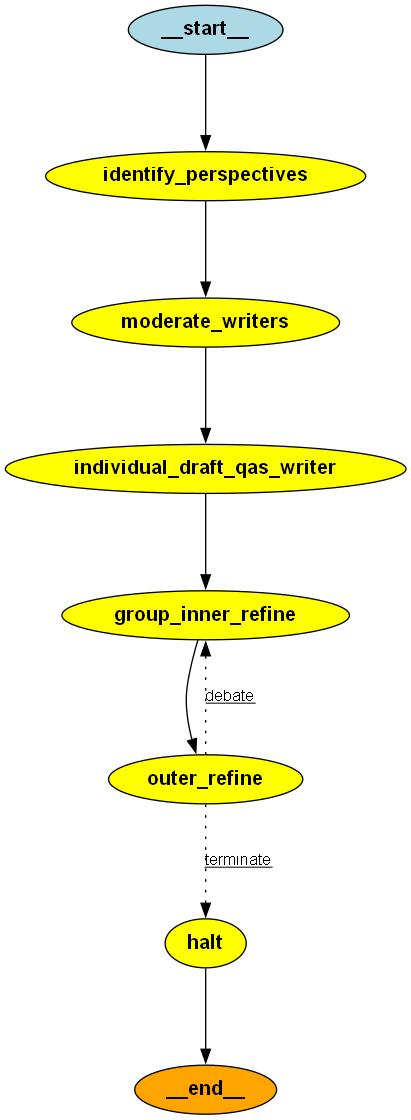

In [35]:
## !conda install conda-forge::pygraphviz
from IPython.display import Image

Image(app.get_graph().draw_png())

In [36]:
document_text_etf_fundindex = "Both ETFs and index funds are investment options that track a market index, but they differ in how you buy and sell them: Index Funds: You can only buy or sell index funds at the end of the trading day, at a price called the net asset value (NAV). This reflects the value of all the underlying holdings in the fund.  Index funds are similar to traditional mutual funds in this regard. ETFs (Exchange-Traded Funds): ETFs trade throughout the day on a stock exchange, just like stocks. So the price can fluctuate throughout the day. This offers more flexibility for buying and selling, but the price you get might be different from the NAV."

inputs = {"document": document_text_etf_fundindex, "num_steps":0, "M": 3, "N": 3, "L":3, "K": 3}
for output in app.stream(inputs):
    for key, value in output.items():
        logger.info(f"Finished running: {key}:")

2024-06-17 17:33:38.057 | INFO     | __main__:identify_perspectives:4 - --- Entering 'identify_perspectives' node ---
2024-06-17 17:33:39.541 | INFO     | __main__:identify_perspectives:14 - Step: 1 - subtopics: {'subtopics': ['finance', 'index funds', 'ETFs']}
2024-06-17 17:33:39.541 | INFO     | __main__:identify_perspectives:16 - --- Leaving 'identify_perspectives' node ---
2024-06-17 17:33:39.552 | INFO     | __main__:<module>:6 - Finished running: identify_perspectives:
2024-06-17 17:33:39.557 | INFO     | __main__:moderate_writers:3 - --- Entering `moderate_writers` node ---
2024-06-17 17:33:40.655 | INFO     | __main__:moderate_writers:20 - type(moderator_response): <class 'dict'>
2024-06-17 17:33:40.658 | INFO     | __main__:moderate_writers:21 - {'writers_instructions': [{'writer_id': 1, 'perspective': 'tax', 'task': "Generate 5 question-answer pairs that are directly grounded in the document's content from the perspective of a tax expert.", 'instructions': ['1. Assign perspec